# Implementation of Autoencoders

We’ve created an autoencoder comprising two Dense layers: 
 - Encoder: responsible for condensing the images into a 64-dimensional latent vector
 - Decoder: tasked with reconstructing the initial image based on this latent space.

### Step 1: Import necessary libraries

For the implementation we are going to import matplotlib, numpy, pandas, sklearn and keras. 

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.datasets import mnist
import os
import math

keras.backend.clear_session()

### Step 2: Load the dataset 

Batch size:  1
Image size:  (201, 201)
Insight into training dataset: 
Cardinality: tf.Tensor(-1, shape=(), dtype=int64)
Input image shape:  (1, 201, 201, 1)
Real image shape:  (1, 201, 201, 1)


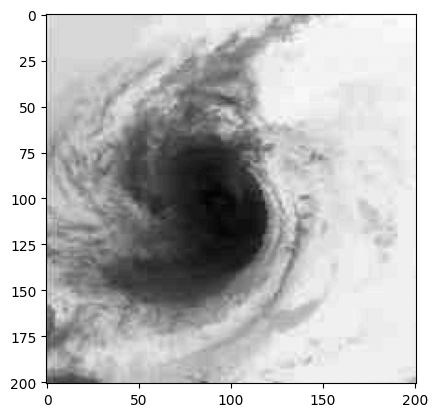

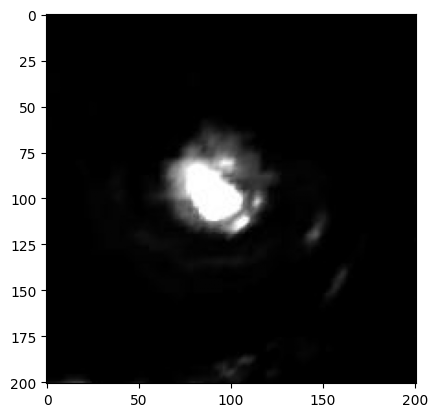

In [141]:


# load an image from a file (split into input and real images)
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

# scale the image to the range [-1, 1]
def normalize(input_image, real_image):
    
    # Convert images to grayscale
    input_image = tf.image.rgb_to_grayscale(input_image)
    real_image = tf.image.rgb_to_grayscale(real_image)

    
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

def load_images(image_file):
    
    input_images, real_images = load(image_file)
    input_images, real_images = normalize(input_images, real_images)

    return input_images, real_images

# Load the dataset
BUFFER_SIZE = 400
BATCH_SIZE = 1

train_dataset = tf.data.Dataset.list_files('./data/TCIRRP/train0.1k/*.jpg')
train_dataset = train_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.Dataset.list_files('./data/TCIRRP/test0.1k/*.jpg')
test_dataset = test_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# shapes
# print("Number of training images: ", len(train_dataset))
# print("Number of test images: ", len(test_dataset))
print("Batch size: ", BATCH_SIZE)
print("Image size: ", next(iter(train_dataset))[0].shape[1:3])

print("Insight into training dataset: ")
print("Cardinality:", tf.data.experimental.cardinality(train_dataset))
for input_image, real_image in train_dataset.take(1):
    print("Input image shape: ", input_image.shape)
    print("Real image shape: ", real_image.shape)
    plt.imshow(input_image[0, :, :, 0], cmap='gray')
    plt.show()
    plt.imshow(real_image[0, :, :, 0], cmap='gray')
    plt.show()

### Step 3: Define the autoencoder architecture
 - Autoencoder class is defined.
 - Constructor initializes the autoencoder with specified latent dimensions and data shape
 - The encoder and decoder architectures is defined using Sequential model
 - The call method defines the forward pass of the autoencoder where input data is passed through the encoder to obtain encoded data and then through the decoder to obtain the decoded data. 

In [128]:
class Autoencoder(Model):
    def __init__(self, w, h, latent_dimensions):
        super(Autoencoder, self).__init__()
        
        # Apply convulutional layers and move from flatten to latent hidden layer
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(w, h, 1)), # one channel (intensity)
            # layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            # layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            # layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])
        
        print("Encoder output shape: ", self.encoder.output_shape)
        print("Encoder input shape: ", self.encoder.input_shape)
        
        # Compute exact feature-map size at bottleneck
        
        self.bw = math.ceil(w / 2**3) # width bottleneck
        self.bh = math.ceil(h / 2**3) # height bottleneck
        self.bc = 128                 # channels bottleneck
                
        self.decoder = tf.keras.Sequential([
            # layers.Input(shape=(latent_dimensions,)),
            # layers.Dense(self.bw * self.bh * self.bc, activation='relu'),
            # layers.Reshape((self.bw, self.bh, self.bc)),
            # layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            # layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            # layers.Conv2DTranspose(1,  3, strides=2, padding='same', activation='sigmoid'),
            # layers.Cropping2D(cropping=((3,4),(3,4)))
            
            ## REMOVE:
            layers.Dense(w * h, activation='relu'),
            layers.Reshape((w, h, 1)),
        ])
    
    
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

### Step 4: Compiling and Fitting Autoencoder 

In [140]:
autoencoder = Autoencoder(w=201, h=201, latent_dimensions=64)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.summary()

autoencoder.fit(train_dataset,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=test_dataset
                )

Encoder output shape:  (None, 64)
Encoder input shape:  (None, 201, 201, 1)


Model: "autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 64)             │     2,585,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,585,728 (9.86 MB)

 Trainable params: 2,585,728 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

Train dataset cardinality just before fit: -1
Sample Input Batch Shape just before fit: (1, 201, 201, 1)
Sample Target Batch Shape just before fit: (1, 201, 201, 1)
Attempting to fit the model...


2025-05-11 10:31:17.349354: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1


InvalidArgumentError: Graph execution error:

Detected at node autoencoder_2_1/sequential_4_1/flatten_2_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3365, in run_cell_async

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3610, in run_ast_nodes

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3670, in run_code

  File "/tmp/ipykernel_18341/2750555803.py", line 33, in <module>

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 59, in train_step

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/tmp/ipykernel_18341/1511331151.py", line 40, in call

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/models/sequential.py", line 221, in call

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/models/functional.py", line 643, in call

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/layers/layer.py", line 910, in __call__

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 4937, in reshape

  File "/home/pedro/Documents/Universidade/3ano/2semestre/TAA/TAA-project-2/env/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 2024, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node autoencoder_2_1/sequential_4_1/flatten_2_1/Reshape}}]] [Op:__inference_multi_step_on_iterator_108357]